In [56]:
# CNN - Anomalies 

# Libraries

import keras
import cv2
import numpy as np
import pandas as pd
from PIL import Image as img

# TensorFlow Backend
import tensorflow as tf # added 
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
    
# Change Image Format
img_size=256

In [57]:
keras.backend.image_data_format()

keras.backend.set_image_data_format("channels_first")
keras.backend.image_data_format()

'channels_first'

In [58]:
#Train Folders
TrainP = "/kaggle/input/cnn-anomalies/Train/AnomaliesAugmentation/*.png"
TrainN = "/kaggle/input/cnn-anomalies/Train/NormalAugmentation/*.png"

#Test Folders
TestP = "/kaggle/input/cnn-anomalies/Test/Anomalies/*.png"
TestN = "/kaggle/input/cnn-anomalies/Test/Normal/*.png"

# Training Data
yes_train_list = glob.glob(TrainP)
no_train_list = glob.glob(TrainN)

In [59]:
#---------- Positive Training Data ---------
x_train = []

for i in tqdm(yes_train_list):
    temp = img.open(i).resize((img_size, img_size))
    temp = temp.convert("L")
    
    x_train.append((np.array(temp) - np.mean(temp)) / np.std(temp))
    x_train.append((np.array(temp.rotate(90)) - np.mean(temp)) / np.std(temp))
    x_train.append((np.array(temp.rotate(180)) - np.mean(temp)) / np.std(temp))
    x_train.append((np.array(temp.rotate(270)) - np.mean(temp)) / np.std(temp))
    

y_train = np.tile(1, len(yes_train_list)*4)
print("Positive images loading is done")


100%|██████████| 1157/1157 [00:21<00:00, 54.01it/s]

Positive images loading is done


In [60]:
#---------- Negative Training Data ---------
for i in tqdm(no_train_list):
    temp = img.open(i).resize((img_size, img_size))
    temp = temp.convert("L")
    
    x_train.append((np.array(temp) - np.mean(temp)) / np.std(temp))
    x_train.append((np.array(temp.rotate(90)) - np.mean(temp)) / np.std(temp))
    x_train.append((np.array(temp.rotate(180)) - np.mean(temp)) / np.std(temp))
    x_train.append((np.array(temp.rotate(270)) - np.mean(temp)) / np.std(temp))
    
y_train = np.concatenate((y_train, np.tile(0, len(no_train_list)*4))).astype("uint8")
print("Negative images loading is done")
a = np.asarray(x_train)
x_train = a.reshape(a.shape[0], 1, a.shape[1], a.shape[2])

del(a)
x_train.shape

100%|██████████| 2483/2483 [00:44<00:00, 55.23it/s]


Negative images loading is done


(14560, 1, 256, 256)

In [61]:
# --------------- Model Design ------------------
from keras.layers import ELU, PReLU, LeakyReLU

img_size=256

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(1, img_size, img_size)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(LeakyReLU(alpha=.01)) 
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(LeakyReLU(alpha=.01)) 
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Conv2D(filters=img_size, activation="relu", kernel_size=(3, 3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=12, activation="relu"))
model.add(keras.layers.Dense(units=1, activation="sigmoid"))

model.summary()

# ---------- Model Compilaton ---------
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(), loss=keras.losses.binary_crossentropy, metrics=["binary_accuracy"])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 254, 254)      320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 127, 127)     0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 32, 127, 127)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 125, 125)      9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 62, 62)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 32, 62, 62)       

In [62]:
# with tf.device('/cpu:0'):
# ---------- Model Training -----------
model.fit(x=x_train, y=y_train, epochs=80, validation_split=0.1, shuffle=True, batch_size=100)
len(model.history.history["binary_accuracy"])
model.save("TrainedCNN")

Epoch 1/80
132/132 [==============================] - 25s 186ms/step - loss: 0.6150 - binary_accuracy: 0.6629 - val_loss: 0.6400 - val_binary_accuracy: 0.4402
Epoch 2/80
132/132 [==============================] - 22s 167ms/step - loss: 0.5625 - binary_accuracy: 0.7204 - val_loss: 0.2619 - val_binary_accuracy: 0.9560
Epoch 3/80
132/132 [==============================] - 22s 167ms/step - loss: 0.5209 - binary_accuracy: 0.7579 - val_loss: 1.4870 - val_binary_accuracy: 0.0192
Epoch 4/80
132/132 [==============================] - 22s 167ms/step - loss: 0.4936 - binary_accuracy: 0.7757 - val_loss: 0.2612 - val_binary_accuracy: 0.9691
Epoch 5/80
132/132 [==============================] - 22s 168ms/step - loss: 0.4560 - binary_accuracy: 0.7962 - val_loss: 2.1832 - val_binary_accuracy: 0.0076
Epoch 6/80
132/132 [==============================] - 22s 168ms/step - loss: 0.4212 - binary_accuracy: 0.8283 - val_loss: 0.0185 - val_binary_accuracy: 1.0000
Epoch 7/80
132/132 [==========================

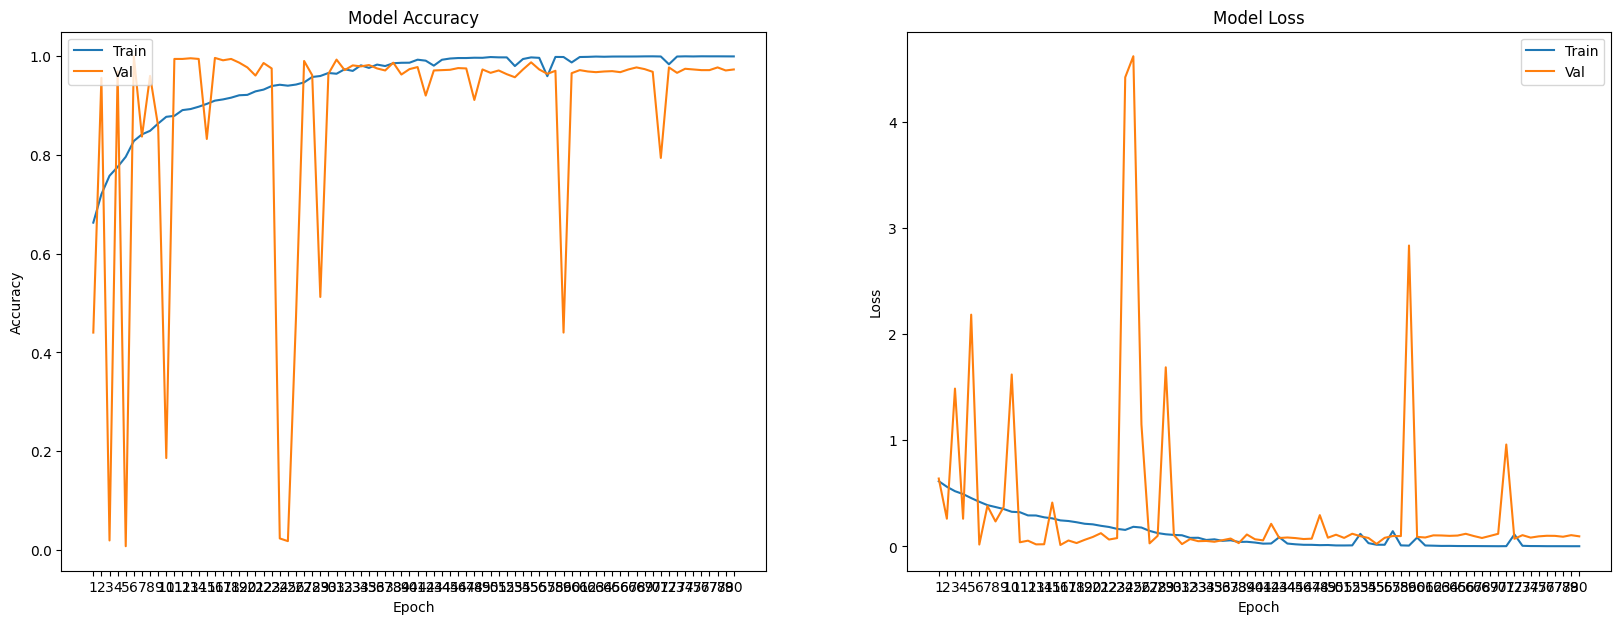

In [63]:
# ----------------Plotting-----------------

plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.plot(model.history.history["binary_accuracy"])
plt.plot(model.history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
#plt.xticks(np.arange(0, len(model.history.history["binary_accuracy"]), 1))

plt.xticks(np.arange(len(model.history.history["binary_accuracy"])), np.arange(1, len(model.history.history["binary_accuracy"])+1, 1))

plt.subplot(1, 2, 2)
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper right")
plt.xticks(np.arange(len(model.history.history["loss"])), np.arange(1, len(model.history.history["loss"])+1, 1))
plt.show()

In [64]:
img_size=256

# Testing

yes_test_list = glob.glob(TestP)
no_test_list = glob.glob(TestN)

x_test = []

for i in tqdm(yes_test_list):
    temp = img.open(i).resize((img_size, img_size))
    temp = temp.convert("L")    
    x_test.append((np.array(temp) - np.mean(temp)) / np.std(temp))

for i in tqdm(no_test_list):
    temp = img.open(i).resize((img_size, img_size))
    temp = temp.convert("L")
    x_test.append((np.array(temp) - np.mean(temp)) / np.std(temp))
    
y_test =[]
y_test = np.tile(1, len(yes_test_list))
y_test = np.concatenate((y_test, np.tile(0, len(no_test_list)))).astype("uint8")

print("test images loading is done")

100%|██████████| 35/35 [00:00<00:00, 71.83it/s]

test images loading is done


In [65]:
# reshaping
a = np.asarray(x_test)
x_test = a.reshape(a.shape[0], 1, a.shape[1], a.shape[2])

del(a)

In [66]:
# Testing
result = model.predict(x=x_test)


test_list = []
idx = []
for i in test_list:
    idx.append(i[21:-4])
    
result = result.reshape(result.shape[0])
result[result>0.5] = 1
result[result<0.5] = 0

total = len(yes_test_list)+len(no_test_list)
correct = (y_test == result).sum()

print('Accuracy: ',correct/total*100, '%')

2/2 [==============================] - 0s 22ms/step
Accuracy:  90.625 %


In [68]:
# Results
total = len(yes_test_list)+len(no_test_list)
total_pos = len(yes_test_list)
total_neg = len(no_test_list)

true_pos = (y_test[0:total_pos] == result[0:total_pos]).sum()
true_neg = (y_test[total_pos+1:total] == result[total_pos+1:total]).sum()

false_neg = total_pos - true_pos # correct version Type II error
false_pos = total_neg - true_neg # correct version

correct = (y_test == result).sum()

Accuracy = ((true_pos+true_neg)/total)*100
Precision = true_pos/((true_pos+false_pos))*100
Recall = true_pos/(true_pos+false_neg)*100
FMeasure = (2 * Precision * Recall) / (Precision + Recall)

print('Accuracy: ',Accuracy, '%')
print('Precision: ',Precision)
print('Recall: ',Recall)
print('F-Measure: ',FMeasure)

print('Total:', total)
print('TP:',true_pos, '   TN:', true_neg)
print('FP:',false_pos, '   FN:', false_neg )

print('False Negative Rate:', false_neg/(false_neg+true_pos))
print('True Positive Rate:', true_pos/(false_neg+true_pos))

Accuracy:  89.0625 %
Precision:  95.83333333333334
Recall:  79.3103448275862
F-Measure:  86.7924528301887
Total: 64
TP: 23    TN: 34
FP: 1    FN: 6
False Negative Rate: 0.20689655172413793
True Positive Rate: 0.7931034482758621
